In [1]:
import pandas as pd
import numpy as py
import matplotlib.pyplot as plt

In [2]:
dataset  = pd.read_json('Sarcasm_Headlines_Dataset.json', lines=True)

In [3]:
##df[df.is_sarcastic == 1]['headline']
len(dataset)

26709

In [4]:
# Cleaning the text
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
corpus = []
for i in range(0, 26709):  # 26709 is the numbers of headlines in the dataset
    review = dataset['headline'][i] 
    review = re.sub('[^a-z]', ' ', review) # removes all symbols besides lowercase letters (everything is lowercase to begin with)
    review = review.split() # split the string into a list of single words for PorterStemmer
    ps = SnowballStemmer("english")
    review = [ps.stem(word) for word in review if not word in stopwords.words('english')] # transform words to their stems and remove stopwords
    review = ' '.join(review) # join the list back to a string
    corpus.append(review) # add it to the corpus

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\İREM\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [8]:
# Creating the bag of words model
y = dataset.iloc[:, 2] # extracting the dependant outcomes
from sklearn.feature_extraction.text import CountVectorizer
features_n = range(100, 3000, 100) # list of different max vectors to try
scores = []
for i in features_n:
    cv = CountVectorizer(max_features = i) # setting the max number different features
    X = cv.fit_transform(corpus).toarray() # transforming list of strings into a matrix of token counts
    
    # Splitting the dataset into the Training set and Test set
    from sklearn.model_selection import train_test_split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 0)

    # Fitting Support Vector Machine to the Training set
    from sklearn.linear_model import LogisticRegression  # "Logistic regression" 
    classifier = LogisticRegression() 
    classifier.fit(X_train, y_train)

    # Predicting the Test set results
    y_pred = classifier.predict(X_test)

    # Making the Confusion Matrix
    from sklearn.metrics import confusion_matrix
    cm = confusion_matrix(y_test, y_pred)
    TP = cm[0][0]
    FP = cm[0][1]
    FN = cm[1][0]
    TN = cm[1][1]
    error_rate = (FP+FN)/(TP+TN+FP+FN) # calculating the error rate based on confusion matrix results
    scores.append(error_rate)

C:\Users\Public\Empty\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Public\Empty\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Public\Empty\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Public\Empty\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Public\Empty\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  

The optimal number of max vectors is 2900 with an error rate of 0.224


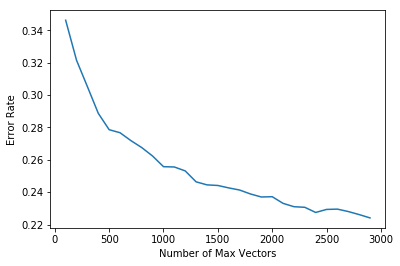

In [9]:
#Printing out the optimal max features value and plot the results
optimal_n = features_n[scores.index(min(scores))]
print ("The optimal number of max vectors is %d" % optimal_n + " with an error rate of %.3f" % min(scores))
plt.plot(features_n, scores)
plt.xlabel('Number of Max Vectors')
plt.ylabel('Error Rate')
plt.show()

In [11]:
#fig, ax = plt.subplots()
#im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
#ax.figure.colorbar(im, ax=ax)
# We want to show all ticks...
#ax.set(xticks=np.arange(cm.shape[1]),
       #yticks=np.arange(cm.shape[0]),
       # ... and label them with the respective list entries
       #xticklabels=classes, yticklabels=classes,
       #title= "Animal Outcomes",
       #ylabel='True label',
       #xlabel='Predicted label')
#fmt = '.2f' if normalize else 'd'
#thresh = cm.max() / 2.
#for i in range(cm.shape[0]):
    #for j in range(cm.shape[1]):
        #ax.text(j, i, format(cm[i, j], fmt),
                #ha="center", va="center",
                #color="white" if cm[i, j] > thresh else "black")
#fig.autofmt_xdate()
#plt.savefig('MLP_WithDeadReturned.png')